In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [
                                                               50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [
                                                         40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


C:\Users\Virag\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Virag\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Using cuda device


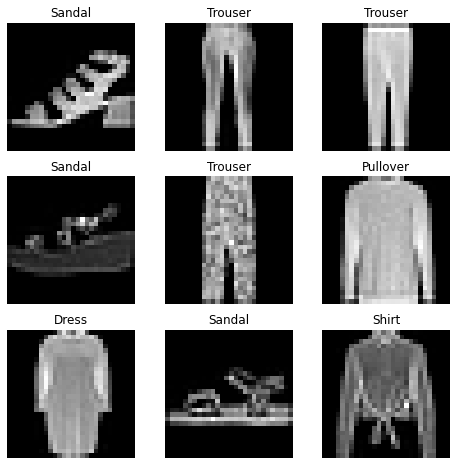

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_neurons=512, input_dim=28*28, output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, output_dim),

        )
        # self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        # output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x


In [3]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss}  [{current}/{size}]")


def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")


def predict(data, model, apply_softmax=True):
    labels = data[1]
    label = labels[0]  # Take first element of batch
    data = data[0]
    data = data[0, :, :, :]  # Take first element of batch
    # First dimension is 1 because image is black & white. Would be 3 for RGB.
    print(f"Size of one sample is {data.size()}")
    pred = model(data)
    if apply_softmax:
        softmax = nn.Softmax()
        pred = softmax(pred)
    pred = pred.detach().numpy()
    pred = pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")


In [4]:
lambdas = [0.000001,0.00001,0.0001,0.001,0.1]
neurons = [200,450,700,950,1200]
learning_rate = 1e-3
batch_size = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
for lam in lambdas:
        for neur in neurons:
                model = NeuralNetwork(n_neurons=neur)
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lam)
                print("lambda: " + str(lam) + "\n number of neurons: " + str(neur))
                for t in range(epochs):
                        print(f"Epoch {t+1}\n-------------------------------")
                        fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
                        print('Validation results:')
                        predict_dataset(validation_dataloader, model, loss_fn)
                print('Test results:')
                predict(next(iter(test_dataloader)), model, loss_fn)
                predict_dataset(test_dataloader, model, loss_fn)


lambda: 1e-06
 number of neurons: 200
Epoch 1
-------------------------------
loss: 2.313537836074829  [0/40000]
loss: 2.2986226081848145  [6400/40000]
loss: 2.281803607940674  [12800/40000]
loss: 2.2758655548095703  [19200/40000]
loss: 2.2629213333129883  [25600/40000]
loss: 2.2542221546173096  [32000/40000]
loss: 2.2416460514068604  [38400/40000]
Validation results:
Error: 
 Accuracy: 33.03%, Avg loss: 2.2384630525188083 

Epoch 2
-------------------------------
loss: 2.251889944076538  [0/40000]
loss: 2.22922945022583  [6400/40000]
loss: 2.2196271419525146  [12800/40000]
loss: 2.206655740737915  [19200/40000]
loss: 2.1864964962005615  [25600/40000]
loss: 2.1743602752685547  [32000/40000]
loss: 2.1515417098999023  [38400/40000]
Validation results:
Error: 
 Accuracy: 41.4%, Avg loss: 2.145116831846298 

Epoch 3
-------------------------------
loss: 2.164926767349243  [0/40000]
loss: 2.133669376373291  [6400/40000]
loss: 2.122817277908325  [12800/40000]
loss: 2.1005890369415283  [19200

C:\Users\Virag\AppData\Local\Temp/ipykernel_16916/3273623465.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(pred)


Error: 
 Accuracy: 66.53999999999999%, Avg loss: 0.9904514862473603 

lambda: 1e-06
 number of neurons: 450
Epoch 1
-------------------------------
loss: 2.2979321479797363  [0/40000]
loss: 2.2793800830841064  [6400/40000]
loss: 2.279857873916626  [12800/40000]
loss: 2.2524330615997314  [19200/40000]
loss: 2.2316348552703857  [25600/40000]
loss: 2.2293901443481445  [32000/40000]
loss: 2.198942184448242  [38400/40000]
Validation results:
Error: 
 Accuracy: 38.36%, Avg loss: 2.2092452185928444 

Epoch 2
-------------------------------
loss: 2.220377206802368  [0/40000]
loss: 2.1912965774536133  [6400/40000]
loss: 2.1960344314575195  [12800/40000]
loss: 2.1564714908599854  [19200/40000]
loss: 2.12496280670166  [25600/40000]
loss: 2.1130619049072266  [32000/40000]
loss: 2.069378614425659  [38400/40000]
Validation results:
Error: 
 Accuracy: 47.260000000000005%, Avg loss: 2.0849524713625573 

Epoch 3
-------------------------------
loss: 2.1095778942108154  [0/40000]
loss: 2.058670997619629

By increasing the number of neurons, the accuracy values increased.
The best accuracy was achieved by 1e-05 lambda and 1200 neurons. It was 71.2%.